In [1]:
import scvelo as scv
import scanpy as sc
import pickle as pickle
from eval_utils import cross_boundary_correctness, inner_cluster_coh
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import unitvelo as utv
method = 'UniTVelo_unified'

(Running UniTVelo 0.2.5)
2023-05-18 15:01:03


In [2]:
datasets = ['Pancreas_with_cc', 'HumanDevelopingBrain', 'MouseBoneMarrow',  'HumanBoneMarrow', 'MouseErythroid',  'DentateGyrus']
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'

Pancreas_with_cc
Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
------> Manully Specified Parameters <------
N_TOP_GENES:	3000
------> Model Configuration Settings <------
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Current working dir is /nfs/team283/aa16/fate_benchmarking.
Results will be stored in res folder
Filtered

Loss (Total): 3011.289, (Spliced): 1477.038, (Unspliced): 1534.251: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11999/12000 [23:08<00:00,  6.86it/s]

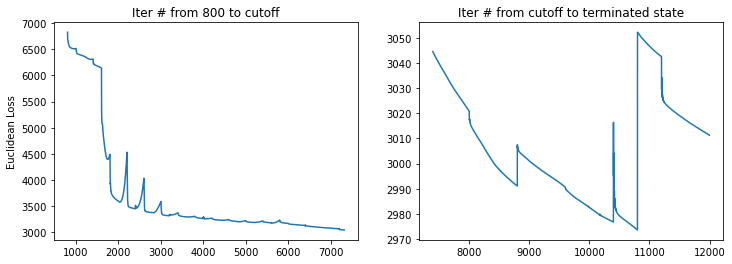

Loss (Total): 3011.289, (Spliced): 1477.038, (Unspliced): 1534.251: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11999/12000 [23:47<00:00,  8.41it/s]

Total loss 2973.603, vgene loss 3011.289


  0%|          | 0/3696 [00:00<?, ?cells/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 high EP', 'Pre-endocrine'): 0.738413507003304, ('Pre-endocrine', 'Alpha'): 0.7688626049532291, ('Pre-endocrine', 'Beta'): 0.828286198748149, ('Pre-endocrine', 'Delta'): 0.4264468070530355, ('Pre-endocrine', 'Epsilon'): -0.014511983060739907}
Total Mean: 0.5494994269393955
# In-cluster Coherence
{'Alpha': 0.9962782, 'Beta': 0.998199, 'Delta': 0.9951236, 'Ductal': 0.99908864, 'Epsilon': 0.99634135, 'Ngn3 high EP': 0.95878947, 'Ngn3 low EP': 0.99797094, 'Pre-endocrine': 0.99480873}
Total Mean: 0.9920749664306641
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 high EP', 'Pre-endocrine'): 0.738413507003304, ('Pre-endocrine', 'Alpha'): 0.7688626049532291, ('Pre-endocrine', 'Beta'): 0.828286198748149, ('Pre-endocrine', 'Delta'): 0.4264468070530355, ('Pre-endocrine', 'Epsilon'): -0.014511983060739907}
Total Mean: 0.5494994269393955
# In-cluster Coherence
{'Alpha': 0.9962782, 'Beta': 0.998199, 'Delta': 0.9951236, 'Ductal': 0.99908864, 

Loss (Total): 955.468, (Spliced): 476.082, (Unspliced): 479.386:   9%|████████████                                                                                                                      | 1111/12000 [02:25<23:23,  7.76it/s]

In [ ]:
for dataset in datasets:
    print(dataset)
    # Load and setup data:
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    adata.var['highly_variable'] = True
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=3000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    velo = utv.config.Configuration()
    velo.N_TOP_GENES = 3000
    velo.R2_ADJUST = True
    velo.IROOT = None
    velo.FIT_OPTION = '1'
    velo.GPU = 0
    velo.vgenes = 'offset'
    scv.pp.neighbors(adata)
    adata = utv.run_model(adata, 'clusters', config_file=velo)
    scv.tl.velocity_graph(adata, vkey='velocity')
    scv.tl.velocity_embedding(adata, vkey='velocity')
    fix, ax = plt.subplots(1, 1, figsize = (8, 6))
    scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                     show = False, ax = ax, legend_fontsize = 13)
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_UniTVelo_unified.svg')
    # Calculate performance metrics:
    adata.layers['velocity'][pd.isna(adata.layers['velocity'])] = 0
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    if exists(save_dir + dataset + '_CBDC_scores.csv'):
        tab = pd.read_csv(save_dir + dataset + '_CBDC_scores.csv', index_col = 0)
    else:
        tab = pd.DataFrame(columns = list(metrics['Cross-Boundary Direction Correctness (A->B)'].keys()) + ['Mean'],
                 index = [method])
    cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
                for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
    tab.loc[method,:] = cb_score + [np.mean(cb_score)]
    tab.to_csv(save_dir + dataset + '_CBDC_scores.csv')
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    if exists(save_dir + dataset + '_ICC_scores.csv'):
        tab = pd.read_csv(save_dir + dataset + '_ICC_scores.csv', index_col = 0)
    else:
        tab = pd.DataFrame(columns = list(np.unique(np.concatenate(ground_truth))) + ['Mean'],
                 index = [method])
    icc_score = [np.mean(metrics['In-cluster Coherence'][x]) for x in np.unique(np.concatenate(ground_truth))]
    tab.loc[method,:] = icc_score + [np.mean(icc_score)]
    tab.to_csv(save_dir + dataset + '_ICC_scores.csv')
    fix, ax = plt.subplots(1, 1, figsize = (8, 6))
    scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                     show = False, ax = ax)
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_' + method + '.svg')